In [9]:
import os
import sys
import matplotlib

import matplotlib.pyplot
import matplotlib.pyplot as plt
import time
import datetime
import argparse
import numpy as np
import pandas as pd
from random import SystemRandom
from sklearn import model_selection
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim

import lib.utils as utils
from lib.plotting import *

from lib.rnn_baselines import *
from lib.ode_rnn import *
from lib.create_latent_ode_model import create_LatentODE_model
from lib.parse_datasets import parse_datasets
from lib.ode_func import ODEFunc, ODEFunc_w_Poisson
from lib.diffeq_solver import DiffeqSolver
from mujoco_physics import HopperPhysics
import os
import numpy as np

import torch
import torch.nn as nn
%matplotlib inline
import lib.utils as utils
from lib.diffeq_solver import DiffeqSolver
from generate_timeseries import Periodic_1d
from torch.distributions import uniform

from torch.utils.data import DataLoader
from mujoco_physics import HopperPhysics
from physionet import variable_time_collate_fn, get_data_min_max
from person_activity import PersonActivity, variable_time_collate_fn_activity

from sklearn import model_selection
import random

from lib.utils import compute_loss_all_batches

In [2]:
# Generative model for noisy data based on ODE
parser = argparse.ArgumentParser('Latent ODE')
parser.add_argument('-n',  type=int, default=10000, help="Size of the dataset")
parser.add_argument('--niters', type=int, default=20)
parser.add_argument('--lr',  type=float, default=1e-2, help="Starting learning rate.")
parser.add_argument('-b', '--batch-size', type=int, default=256)
parser.add_argument('--viz', action='store_true', default=False, help="Show plots while training")

parser.add_argument('--save', type=str, default='experiments/', help="Path for save checkpoints")
parser.add_argument('--load', type=str, default=None, help="ID of the experiment to load for evaluation. If None, run a new experiment.")
parser.add_argument('-r', '--random-seed', type=int, default=1991, help="Random_seed")

parser.add_argument('--dataset', type=str, default='physionet', help="Dataset to load. Available: physionet, activity, hopper, periodic")
parser.add_argument('-s', '--sample-tp', type=float, default=None, help="Number of time points to sub-sample."
	"If > 1, subsample exact number of points. If the number is in [0,1], take a percentage of available points per time series. If None, do not subsample")

parser.add_argument('-c', '--cut-tp', type=int, default=None, help="Cut out the section of the timeline of the specified length (in number of points)."
	"Used for periodic function demo.")

parser.add_argument('--quantization', type=float, default=5, help="Quantization on the physionet dataset."
	"Value 1 means quantization by 1 hour, value 0.1 means quantization by 0.1 hour = 6 min")

parser.add_argument('--latent-ode', action='store_true', default=True,  help="Run Latent ODE seq2seq model")
parser.add_argument('--z0-encoder', type=str, default='odernn', help="Type of encoder for Latent ODE model: odernn or rnn")

parser.add_argument('--classic-rnn', action='store_true', help="Run RNN baseline: classic RNN that sees true points at every point. Used for interpolation only.")
parser.add_argument('--rnn-cell', default="gru", help="RNN Cell type. Available: gru (default), expdecay")
parser.add_argument('--input-decay', action='store_true', help="For RNN: use the input that is the weighted average of impirical mean and previous value (like in GRU-D)")

parser.add_argument('--ode-rnn', action='store_true', help="Run ODE-RNN baseline: RNN-style that sees true points at every point. Used for interpolation only.")

parser.add_argument('--rnn-vae', action='store_true', help="Run RNN baseline: seq2seq model with sampling of the h0 and ELBO loss.")

parser.add_argument('-l', '--latents', type=int, default=6, help="Size of the latent state")
parser.add_argument('--rec-dims', type=int, default=40, help="Dimensionality of the recognition model (ODE or RNN).")

parser.add_argument('--rec-layers', type=int, default=3, help="Number of layers in ODE func in recognition ODE")
parser.add_argument('--gen-layers', type=int, default=3, help="Number of layers in ODE func in generative ODE")

parser.add_argument('-u', '--units', type=int, default=50, help="Number of units per layer in ODE func")
parser.add_argument('-g', '--gru-units', type=int, default=100, help="Number of units per layer in each of GRU update networks")

parser.add_argument('--poisson', action='store_true', help="Model poisson-process likelihood for the density of events in addition to reconstruction.")
parser.add_argument('--classif', action='store_true', help="Include binary classification loss -- used for Physionet dataset for hospiral mortality")

parser.add_argument('--linear-classif', action='store_true', help="If using a classifier, use a linear classifier instead of 1-layer NN")
parser.add_argument('--extrap', action='store_true', help="Set extrapolation mode. If this flag is not set, run interpolation mode.")

parser.add_argument('-t', '--timepoints', type=int, default=100, help="Total number of time-points")
parser.add_argument('--max-t',  type=float, default=5., help="We subsample points in the interval [0, args.max_tp]")
parser.add_argument('--noise-weight', type=float, default=0.01, help="Noise amplitude for generated traejctories")


args = parser.parse_args([])
args.batch_size = 64
args.classif = False
args.quantization = 5
args.niters = 100 
args.n = 30
args.s =50
args.l = 20
args.rec_dims = 40
args.rec_layers = 3
args.gen_layers = 3
args.latent_ode
args.viz
file_name = 'taejun_1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


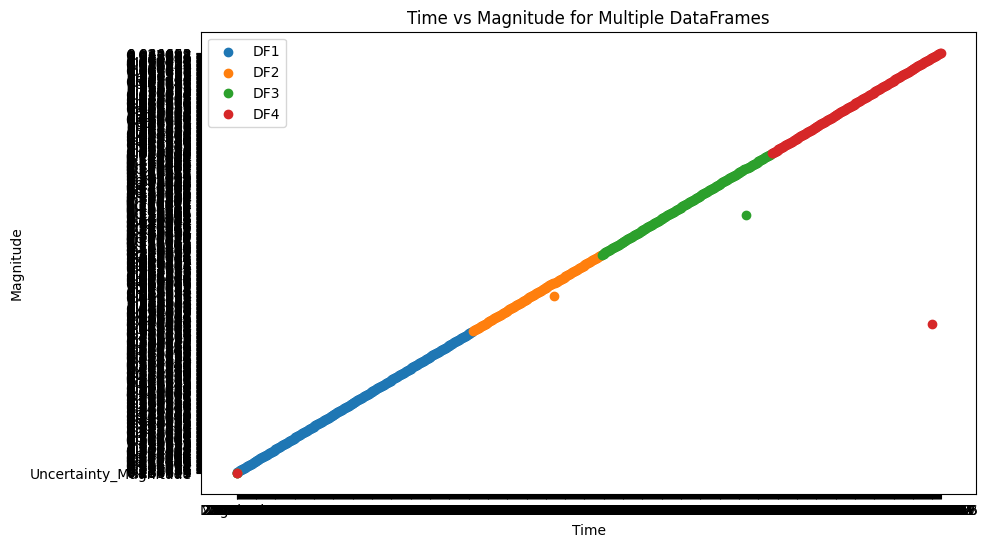

In [13]:
import pandas as pd
import glob
#import matscatterlib.pyscatter as plt

# lc 파일들이 있는 폴더 경로를 지정하세요.
folder_path = '/home/intern/SSD/intern/taejun/test_light'
file_paths = glob.glob(f'{folder_path}/*.txt')

# 최대 4개의 파일만 읽기
file_paths = file_paths[:4]

# 데이터프레임 변수 초기화
dfs = []

# 각 파일을 순회하면서 데이터 읽기
for file_path in file_paths:
    df = pd.read_csv(file_path, sep="\s+", names=["time", "magnitude", "sd"])
    dfs.append(df)

# dfs 리스트에서 개별 데이터프레임 할당
df1, df2, df3, df4 = dfs

# 그래프 시각화
plt.figure(figsize=(10, 6))
plt.scatter(df1['time'], df1['magnitude'], label='DF1')
plt.scatter(df2['time'], df2['magnitude'], label='DF2')
plt.scatter(df3['time'], df3['magnitude'], label='DF3')
plt.scatter(df4['time'], df4['magnitude'], label='DF4')

plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Time vs Magnitude for Multiple DataFrames')
plt.legend()
plt.show()


In [6]:
df_combined

,time,magnitude,sd
0,58313.480521,18.163679,0.048355
1,58329.459641,18.160948,0.048271
2,58332.459051,18.175394,0.048717
3,58335.481273,18.158321,0.048191
4,58338.438264,18.171848,0.048607
...,...,...,...
410,59801.398171,19.721443,0.136044
411,59815.418912,20.110867,0.165966
412,59819.377338,19.910084,0.151027
413,59822.357512,20.008970,0.158620


In [4]:
import matplotlib.pyplot as plt

# 시간(time)에 따른 밝기(magnitude) 그래프 그리기
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
plt.plot(df_combined['time'], df_combined['magnitude'], 'o-', label='Magnitude')  # 점과 선으로 그래프 그리기
plt.xlabel('Time')  # x축 레이블
plt.ylabel('Magnitude')  # y축 레이블
plt.title('Time vs Magnitude')  # 그래프 제목
plt.gca().invert_yaxis()  # 밝기(magnitude)는 값이 작을수록 밝기 때문에 y축을 역으로 표시
plt.legend()  # 범례 표시
plt.show()


# 데이터 전처리
* r폴더 g폴더 l폴더 분류

In [21]:

# import os
# import shutil

# # 데이터 폴더와 대상 폴더 경로 설정
# source_folder = '/home/intern/SSD/intern/taejun/processed_light_curves'
# target_folder_g = '/home/intern/SSD/intern/taejun/g_light_curves'
# target_folder_r = '/home/intern/SSD/intern/taejun/r_light_curves'
# target_folder_l = '/home/intern/SSD/intern/taejun/l_light_curves'

# # 각 대상 폴더가 없으면 생성
# for folder in [target_folder_g, target_folder_r, target_folder_l]:
#     if not os.path.exists(folder):
#         os.makedirs(folder)

# # 데이터 폴더 내의 파일들을 순회
# for filename in os.listdir(source_folder):
#     if 'r' in filename:  # 파일 이름에 'r'이 포함되어 있는지 확인
#         source_path = os.path.join(source_folder, filename)
#         target_path = os.path.join(target_folder_r, filename)
#         shutil.move(source_path, target_path)
#     elif 'g' in filename:  # 파일 이름에 'g'이 포함되어 있는지 확인
#         source_path = os.path.join(source_folder, filename)
#         target_path = os.path.join(target_folder_g, filename)
#         shutil.move(source_path, target_path)
#     elif 'l' in filename:  # 파일 이름에 'l'이 포함되어 있는지 확인
#         source_path = os.path.join(source_folder, filename)
#         target_path = os.path.join(target_folder_l, filename)
#         shutil.move(source_path, target_path)

# print("이동 완료")
# 

# 데이터 전처리
* Physionet 클래스 만들기

In [22]:
import os
import torch
from tqdm import tqdm
from jdcal import jd2gcal
from datetime import datetime

class CustomClass(object):
    params = ['Magnitude']  # Uncertainty_of_Magnitude 제외

    params_dict = {k: i for i, k in enumerate(params)}

    def __init__(self, root, train=True, preprocess=False,
                 quantization=1, n_samples=None, device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
        self.root = root
        self.train = train
        self.quantization = quantization
        self.device = device
        self.reduce = "average"
        if preprocess:
            self.preprocess()

        self.data = torch.load(os.path.join(self.root, 'lc_' + str(self.quantization) + '.pt'))
        self.labels = torch.zeros(len(self.data))

        if n_samples is not None:
            self.data = self.data[:n_samples]
            self.labels = self.labels[:n_samples]

    def jd_to_total_hours(self,jd):
        jd_int = int(jd)
        jd_frac = jd - jd_int
        # jd2gcal 함수를 사용하여 율리우스 일을 그레고리언 날짜로 변환
        # 이 예에서는 jd2gcal 함수의 정의나 import 방법이 제공되지 않았으므로, 해당 함수의 정확한 동작을 가정합니다.
        year, month, day, fraction = jd2gcal(jd_int, jd_frac)
        # 연도 계산이 특정 요구 사항에 맞게 조정되어 있습니다.
        year = (year + 4553) + 2000
        hours = int(fraction * 24)
        converted_datetime = datetime(year, month, day, hours)
        unix_start = datetime(1970, 1, 1)
        total_hours = int((converted_datetime - unix_start).total_seconds() / 3600)
        return total_hours

    def preprocess(self):
        simulation_data_root = self.root 
        data_list = [f for f in os.listdir(simulation_data_root) if f.endswith('.lc')]
        data_list.sort()
        light_curves = []

        for name in tqdm(data_list):
            lc_name = name.partition('.')[0]
            with open(os.path.join(simulation_data_root, name)) as f:
                lines = f.readlines()
                prev_time = 0
                tt = [0.]
                vals = [torch.zeros(len(self.params), device=self.device)]
                mask = [torch.zeros(len(self.params), device=self.device)]
                for line in lines:
                    time, magnitude = line.rstrip().split(' ')[:2]
                    magnitude = float(magnitude)
                    time = self.jd_to_total_hours(float(time))

                    if time != prev_time:
                        tt.append(time)
                        vals.append(torch.zeros(len(self.params), device=self.device))
                        mask.append(torch.zeros(len(self.params), device=self.device))
                        prev_time = time

                    vals[-1][0] = magnitude
                    mask[-1][0] = 1

            tt = torch.tensor(tt, device=self.device)[1:]
            vals = torch.stack(vals)[1:]
            mask = torch.stack(mask)[1:]
            labels = None
            light_curves.append((lc_name, tt, vals, mask, labels))

        torch.save(light_curves, os.path.join(self.root, 'lc_' + str(self.quantization) + '.pt'))
        print('Done!')

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Split: {}\n'.format('train' if self.train else 'test')
        fmt_str += '    Root Location: {}\n'.format(self.root)
        fmt_str += '    Quantization: {}\n'.format(self.quantization)
        fmt_str += '    Reduce: {}\n'.format(self.reduce)
        return fmt_str

    def visualize(self, timesteps, data, mask, plot_name):
        width = 15
        height = 15

        non_zero_attributes = (torch.sum(mask,0) > 2).numpy()
        non_zero_idx = [i for i in range(len(non_zero_attributes)) if non_zero_attributes[i] == 1.]
        n_non_zero = sum(non_zero_attributes)

        mask = mask[:, non_zero_idx]
        data = data[:, non_zero_idx]

        params_non_zero = [self.params[i] for i in non_zero_idx]
        params_dict = {k: i for i, k in enumerate(params_non_zero)}

        n_col = 3
        n_row = n_non_zero // n_col + (n_non_zero % n_col > 0)
        fig, ax_list = plt.subplots(n_row, n_col, figsize=(width, height), facecolor='white')

        #for i in range(len(self.params)):
        for i in range(n_non_zero):
            param = params_non_zero[i]
            param_id = params_dict[param]

            tp_mask = mask[:,param_id].long()

            tp_cur_param = timesteps[tp_mask == 1.]
            data_cur_param = data[tp_mask == 1., param_id]

            ax_list[i // n_col, i % n_col].plot(tp_cur_param.numpy(), data_cur_param.numpy(),  marker='o') 
            ax_list[i // n_col, i % n_col].set_title(param)

        fig.tight_layout()
        fig.savefig(plot_name)
        plt.close(fig)


            # 예제 사용
            # device 설정: CUDA 사용 가능한 경우 CUDA 사용, 그렇지 않으면 CPU 사용
            #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            # CustomClass 객체 생성 예제
            #simulation_sdss = CustomClass(root='/home/intern/SSD/intern/taejun/test', train=True, preprocess=True,quantization=1, device=device)

            # 객체 생성 시, preprocess=True로 설정하여 데이터 전처리 및 저장이 이루어집니다.


In [23]:
# import torch

# # .pt 파일의 경로 설정
# pt_file_path = '/home/intern/SSD/intern/taejun/test_preprocess/lc_1.pt'

# # .pt 파일 로드
# light_curves_data = torch.load(pt_file_path)

# # 로드된 데이터의 타입과 크기 확인
# print(f"Loaded data type: {type(light_curves_data)}")
# print(f"Number of light curves in the dataset: {len(light_curves_data)}")

# # 첫 번째 광도곡선 데이터의 구조 확인
# first_light_curve = light_curves_data[0]
# print(f"Structure of a single light curve data: {type(first_light_curve)}")
# print(f"Record ID: {first_light_curve[0]}")
# print(f"Time stamps tensor shape: {first_light_curve[1].shape}")
# print(f"Magnitude tensor shape: {first_light_curve[2].shape}")
# print(f"Mask tensor shape: {first_light_curve[3].shape}")
# #print(f"Labels tensor shape: {first_light_curve[4].shape}")

# # 첫 번째 광도곡선 데이터의 일부 내용 출력
# print("\nSample data from the first light curve:")
# print(f"Time stamps: {first_light_curve[1][:5]}")  # 처음 5개의 시간 스탬프
# print(f"Magnitude: {first_light_curve[2][:5, 0]}")  # 처음 5개의 광도 값

# # 두 번째 광도곡선 데이터의 구조 확인
# first_light_curve = light_curves_data[1]
# print(f"Structure of a single light curve data: {type(first_light_curve)}")
# print(f"Record ID: {first_light_curve[0]}")
# print(f"Time stamps tensor shape: {first_light_curve[1].shape}")
# print(f"Magnitude tensor shape: {first_light_curve[2].shape}")
# print(f"Mask tensor shape: {first_light_curve[3].shape}")
# #print(f"Labels tensor shape: {first_light_curve[4].shape}")

# # 두 번째 광도곡선 데이터의 일부 내용 출력
# print("\nSample data from the first light curve:")
# print(f"Time stamps: {first_light_curve[1][:5]}")  # 처음 5개의 시간 스탬프
# print(f"Magnitude: {first_light_curve[2][:5, 0]}")  # 처음 5개의 광도 값

# # # 세 번째 광도곡선 데이터의 구조 확인
# # first_light_curve = light_curves_data[2]
# # print(f"Structure of a single light curve data: {type(first_light_curve)}")
# # print(f"Record ID: {first_light_curve[0]}")
# # print(f"Time stamps tensor shape: {first_light_curve[1].shape}")
# # print(f"Magnitude tensor shape: {first_light_curve[2].shape}")
# # print(f"Mask tensor shape: {first_light_curve[3].shape}")
# # #print(f"Labels tensor shape: {first_light_curve[4].shape}")

# # # 세 번째 광도곡선 데이터의 일부 내용 출력
# # print("\nSample data from the first light curve:")
# # print(f"Time stamps: {first_light_curve[1][:5]}")  # 처음 5개의 시간 스탬프
# # print(f"Magnitude: {first_light_curve[2][:5, 0]}")  # 처음 5개의 광도 값

# 데이터 전처리
* 배치 정보 만들기

In [24]:
#코드에 구현된거 하지만 잘 안된다 수정해서 해보자
def variable_time_collate_fn(batch, args, device = torch.device, data_type = "train", 
	data_min = None, data_max = None):
	"""
	Expects a batch of time series data in the form of (record_id, tt, vals, mask, labels) where
		- record_id is a patient id
		- tt is a 1-dimensional tensor containing T time values of observations.
		- vals is a (T, D) tensor containing observed values for D variables.
		- mask is a (T, D) tensor containing 1 where values were observed and 0 otherwise.
		- labels is a list of labels for the current patient, if labels are available. Otherwise None.
	Returns:
		combined_tt: The union of all time observations.
		combined_vals: (M, T, D) tensor containing the observed values.
		combined_mask: (M, T, D) tensor containing 1 where values were observed and 0 otherwise.
	"""
	D = batch[0][2].shape[1]
	combined_tt, inverse_indices = torch.unique(torch.cat([ex[1] for ex in batch]), sorted=True, return_inverse=True)
	combined_tt = combined_tt.to(device)

	offset = 0
	combined_vals = torch.zeros([len(batch), len(combined_tt), D]).to(device)
	combined_mask = torch.zeros([len(batch), len(combined_tt), D]).to(device)
	
	combined_labels = None
	N_labels = 1

	combined_labels = torch.zeros(len(batch), N_labels) + torch.tensor(float('nan'))
	combined_labels = combined_labels.to(device = device)
	
	for b, (record_id, tt, vals, mask, labels) in enumerate(batch):
		tt = tt.to(device)
		vals = vals.to(device)
		mask = mask.to(device)
		if labels is not None:
			labels = labels.to(device)

		indices = inverse_indices[offset:offset + len(tt)]
		offset += len(tt)

		combined_vals[b, indices] = vals
		combined_mask[b, indices] = mask

		if labels is not None:
			combined_labels[b] = labels

	combined_vals, _, _ = utils.normalize_masked_data(combined_vals, combined_mask, 
		att_min = data_min, att_max = data_max)

	if torch.max(combined_tt) != 0.:
		combined_tt = combined_tt / torch.max(combined_tt)
		
	data_dict = {
		"data": combined_vals, 
		"time_steps": combined_tt,
		"mask": combined_mask,
		"labels": combined_labels}

	data_dict = utils.split_and_subsample_batch(data_dict, args, data_type = data_type)
	return data_dict

In [25]:
# def variable_time_collate_fn(batch, args, device=torch.device("cpu"), data_type="train", data_min=None, data_max=None):
#     D = batch[0][2].shape[1]  # 데이터 차원(D)을 추출합니다.
#     combined_tt = torch.unique(torch.cat([ex[1] for ex in batch]), sorted=True).to(device)  # 모든 타임스텝을 합치고 중복을 제거합니다.

#     combined_vals = torch.zeros([len(batch), len(combined_tt), D], device=device)  # 합쳐진 타임스텝에 대한 데이터 텐서를 초기화합니다.
#     combined_mask = torch.zeros([len(batch), len(combined_tt), D], device=device)  # 마스크 텐서도 같은 방식으로 초기화합니다.

#     for b, (_, tt, vals, mask, _) in enumerate(batch):
#         for t_idx, t in enumerate(tt):
#             idx = (combined_tt == t).nonzero(as_tuple=True)[0]  # 현재 타임스텝의 인덱스를 찾습니다.
#             combined_vals[b, idx] = vals[t_idx]  # 데이터를 배치의 해당 위치에 할당합니다.
#             combined_mask[b, idx] = mask[t_idx]  # 마스크도 마찬가지로 할당합니다.

#     # 정규화를 수행합니다. data_min과 data_max가 제공되지 않는 경우, 데이터 범위를 기반으로 정규화를 수행할 수 있습니다.
#     # 여기서는 예시로 정규화 과정을 생략하며, 필요한 경우 직접 구현할 수 있습니다.
#     if data_min is not None and data_max is not None:
#         combined_vals = (combined_vals - data_min) / (data_max - data_min)

#     # 데이터 분할 및 샘플링 관련 로직은 생략되었습니다. args와 data_type을 기반으로 필요한 처리를 여기에 추가할 수 있습니다.

#     data_dict= {
#         "data": combined_vals,
#         "time_steps": combined_tt,
#         "mask": combined_mask,
#         "laabels": None
#     }
#     data_dict = utils.split_and_subsample_batch(data_dict, args, data_type = data_type)
#     return data_dict


In [26]:
# import torch

# # .pt 파일의 경로 설정
# pt_file_path = '/home/intern/SSD/intern/taejun/test/lc_1.pt'

# # .pt 파일 로드
# light_curves_data = torch.load(pt_file_path)

# # 로드된 데이터의 타입과 크기 확인
# print(f"Loaded data type: {type(light_curves_data)}")
# print(f"Number of light curves in the dataset: {len(light_curves_data)}")

# # 첫 번째 광도곡선 데이터의 구조 확인
# first_light_curve = light_curves_data[0]
# print(f"Structure of a single light curve data: {type(first_light_curve)}")
# print(f"Record ID: {first_light_curve[0]}")
# print(f"Time stamps tensor shape: {first_light_curve[1].shape}")
# print(f"Magnitude tensor shape: {first_light_curve[2].shape}")
# print(f"Mask tensor shape: {first_light_curve[3].shape}")
# print(f"Labels tensor shape: {first_light_curve[4].shape}")

# # 첫 번째 광도곡선 데이터의 일부 내용 출력
# print("\nSample data from the first light curve:")
# print(f"Time stamps: {first_light_curve[1][:5]}")  # 처음 5개의 시간 스탬프
# print(f"Magnitude: {first_light_curve[2][:5, 0]}")  # 처음 5개의 광도 값

# # 두 번째 광도곡선 데이터의 구조 확인
# first_light_curve = light_curves_data[1]
# print(f"Structure of a single light curve data: {type(first_light_curve)}")
# print(f"Record ID: {first_light_curve[0]}")
# print(f"Time stamps tensor shape: {first_light_curve[1].shape}")
# print(f"Magnitude tensor shape: {first_light_curve[2].shape}")
# print(f"Mask tensor shape: {first_light_curve[3].shape}")
# print(f"Labels tensor shape: {first_light_curve[4].shape}")

# # 두 번째 광도곡선 데이터의 일부 내용 출력
# print("\nSample data from the first light curve:")
# print(f"Time stamps: {first_light_curve[1][:5]}")  # 처음 5개의 시간 스탬프
# print(f"Magnitude: {first_light_curve[2][:5, 0]}")  # 처음 5개의 광도 값

# # 세 번째 광도곡선 데이터의 구조 확인
# first_light_curve = light_curves_data[2]
# print(f"Structure of a single light curve data: {type(first_light_curve)}")
# print(f"Record ID: {first_light_curve[0]}")
# print(f"Time stamps tensor shape: {first_light_curve[1].shape}")
# print(f"Magnitude tensor shape: {first_light_curve[2].shape}")
# print(f"Mask tensor shape: {first_light_curve[3].shape}")
# print(f"Labels tensor shape: {first_light_curve[4].shape}")

# # 세 번째 광도곡선 데이터의 일부 내용 출력
# print("\nSample data from the first light curve:")
# print(f"Time stamps: {first_light_curve[1][:5]}")  # 처음 5개의 시간 스탬프
# print(f"Magnitude: {first_light_curve[2][:5, 0]}")  # 처음 5개의 광도 값

In [27]:
train_dataset_obj = CustomClass(root='/home/intern/SSD/intern/taejun/g_light_curves', train=True, preprocess=True,quantization=1,n_samples = min(10000, args.n), device=device)
		# Use custom collate_fn to combine samples with arbitrary time observations.
		# Returns the dataset along with mask and time steps


# Combine and shuffle samples from physionet Train and physionet Test
total_dataset = train_dataset_obj[:len(train_dataset_obj)]



# Shuffle and split
train_data, test_data = model_selection.train_test_split(total_dataset, train_size= 0.8, 
    random_state = 42, shuffle = True)

record_id, tt, vals, mask, labels = train_data[0]

n_samples = len(total_dataset)
input_dim = vals.size(-1)

batch_size = min(min(len(train_dataset_obj), args.batch_size), args.n)
data_min, data_max = get_data_min_max(total_dataset)

train_dataloader = DataLoader(train_data, batch_size= batch_size, shuffle=False, 
    collate_fn= lambda batch: variable_time_collate_fn(batch, args, device, data_type = "train",
        data_min = data_min, data_max = data_max))
test_dataloader = DataLoader(test_data, batch_size = n_samples, shuffle=False, 
    collate_fn= lambda batch: variable_time_collate_fn(batch, args, device, data_type = "test",
        data_min = data_min, data_max = data_max))

attr_names = train_dataset_obj.params
data_objects = {"dataset_obj": train_dataset_obj, 
            "train_dataloader": utils.inf_generator(train_dataloader), 
            "test_dataloader": utils.inf_generator(test_dataloader),
            "input_dim": input_dim,
            "n_train_batches": len(train_dataloader),
            "n_test_batches": len(test_dataloader),
            "attr": attr_names, #optional
            }


  0%|          | 1/8407 [00:00<1:48:59,  1.29it/s]

100%|██████████| 8407/8407 [1:32:47<00:00,  1.51it/s]  


Done!


In [28]:
len(train_dataset_obj)

1000

In [5]:
first_batch = next(iter(train_dataloader))

# 첫 번째 배치의 실제 내용을 출력하여 어떤 키가 있는지 확인
print(first_batch.keys())

# 첫 번째 배치의 구성요소들의 shape를 출력
print("observed_data:", first_batch['observed_data'].shape)
print("observed_tp:", first_batch['observed_tp'].shape)
print("data_to_predict:", first_batch['data_to_predict'].shape)
print("tp_to_predict:", first_batch['tp_to_predict'].shape)
print("observed_mask:", first_batch['observed_mask'].shape)
print("mask_predicted_data", first_batch['mask_predicted_data'].shape)

NameError: name 'train_dataloader' is not defined

In [30]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# # 첫 번째 배치의 데이터 로드
# first_batch = next(iter(train_dataloader))

# # observed_tp와 observed_data 추출
# observed_tp = first_batch['observed_tp'].cpu().numpy()
# observed_data = first_batch['observed_data'].cpu().numpy().squeeze()

# # tp_to_predict와 data_to_predict 추출
# tp_to_predict = first_batch['tp_to_predict'].cpu().numpy()
# data_to_predict = first_batch['data_to_predict'].cpu().numpy().squeeze()

# # 그래프 그리기
# plt.figure(figsize=(10, 5))

# # 실제 관측된 데이터를 플롯
# plt.plot(observed_tp, observed_data, label='Observed Data', marker='o', linestyle='-', color='blue')

# # 예측된 데이터를 플롯
# plt.plot(tp_to_predict, data_to_predict, label='Predicted Data', marker='x', linestyle='--', color='red')

# plt.title('Comparison of Observed and Predicted Data')
# plt.xlabel('Time Points')
# plt.ylabel('Data Values')
# plt.legend()
# plt.show()


In [31]:
first_batch = next(iter(test_dataloader))

# 첫 번째 배치의 실제 내용을 출력하여 어떤 키가 있는지 확인
print(first_batch.keys())

# 첫 번째 배치의 구성요소들의 shape를 출력
print("observed_data:", first_batch['observed_data'].shape)
print("observed_tp:", first_batch['observed_tp'].shape)
print("data_to_predict:", first_batch['data_to_predict'].shape)
print("tp_to_predict:", first_batch['tp_to_predict'].shape)
print("observed_mask:", first_batch['observed_mask'].shape)
print("mask_predicted_data", first_batch['mask_predicted_data'].shape)

dict_keys(['observed_data', 'observed_tp', 'data_to_predict', 'tp_to_predict', 'observed_mask', 'mask_predicted_data', 'labels', 'mode'])
observed_data: torch.Size([200, 472, 1])
observed_tp: torch.Size([472])
data_to_predict: torch.Size([200, 472, 1])
tp_to_predict: torch.Size([472])
observed_mask: torch.Size([200, 472, 1])
mask_predicted_data torch.Size([200, 472, 1])


In [32]:
data_objects

{'dataset_obj': Dataset CustomClass
     Number of datapoints: 1000
     Split: train
     Root Location: /home/intern/SSD/intern/taejun/g_light_curves
     Quantization: 1
     Reduce: average,
 'train_dataloader': <generator object inf_generator at 0x7f4636f43f90>,
 'test_dataloader': <generator object inf_generator at 0x7f4636f43430>,
 'input_dim': 1,
 'n_train_batches': 13,
 'n_test_batches': 1,
 'attr': ['Magnitude']}

In [33]:
if __name__ == '__main__':
	torch.manual_seed(args.random_seed)
	np.random.seed(args.random_seed)

	experimentID = args.load
	if experimentID is None:
		# Make a new experiment ID
		experimentID = int(SystemRandom().random()*100000)
	ckpt_path = os.path.join(args.save, "experiment_" + str(experimentID) + '.ckpt')

	start = time.time()
	print("Sampling dataset of {} training examples".format(args.n))
	
	input_command = sys.argv
	ind = [i for i in range(len(input_command)) if input_command[i] == "--load"]
	if len(ind) == 1:
		ind = ind[0]
		input_command = input_command[:ind] + input_command[(ind+2):]
	input_command = " ".join(input_command)

	utils.makedirs("results/")

	##################################################################
	data_obj = data_objects #이게 원래는 parse_datasets(args, device)
	input_dim = data_obj["input_dim"]

	classif_per_tp = False
	if ("classif_per_tp" in data_obj):
		# do classification per time point rather than on a time series as a whole
		classif_per_tp = data_obj["classif_per_tp"]

	if args.classif and (args.dataset == "hopper" or args.dataset == "periodic"):
		raise Exception("Classification task is not available for MuJoCo and 1d datasets")

	n_labels = 1
	if args.classif:
		if ("n_labels" in data_obj):
			n_labels = data_obj["n_labels"]
		else:
			raise Exception("Please provide number of labels for classification task")

	##################################################################
	# Create the model
	obsrv_std = 0.01
	if args.dataset == "hopper":
		obsrv_std = 1e-3 

	obsrv_std = torch.Tensor([obsrv_std]).to(device)

	z0_prior = Normal(torch.Tensor([0.0]).to(device), torch.Tensor([1.]).to(device))

	if args.rnn_vae:
		if args.poisson:
			print("Poisson process likelihood not implemented for RNN-VAE: ignoring --poisson")

		# Create RNN-VAE model
		model = RNN_VAE(input_dim, args.latents, 
			device = device, 
			rec_dims = args.rec_dims, 
			concat_mask = True, 
			obsrv_std = obsrv_std,
			z0_prior = z0_prior,
			use_binary_classif = args.classif,
			classif_per_tp = classif_per_tp,
			linear_classifier = args.linear_classif,
			n_units = args.units,
			input_space_decay = args.input_decay,
			cell = args.rnn_cell,
			n_labels = n_labels,
			train_classif_w_reconstr = (args.dataset == "physionet")
			).to(device)


	elif args.classic_rnn:
		if args.poisson:
			print("Poisson process likelihood not implemented for RNN: ignoring --poisson")

		if args.extrap:
			raise Exception("Extrapolation for standard RNN not implemented")
		# Create RNN model
		model = Classic_RNN(input_dim, args.latents, device, 
			concat_mask = True, obsrv_std = obsrv_std,
			n_units = args.units,
			use_binary_classif = args.classif,
			classif_per_tp = classif_per_tp,
			linear_classifier = args.linear_classif,
			input_space_decay = args.input_decay,
			cell = args.rnn_cell,
			n_labels = n_labels,
			train_classif_w_reconstr = (args.dataset == "physionet")
			).to(device)
	elif args.ode_rnn:
		# Create ODE-GRU model
		n_ode_gru_dims = args.latents
				
		if args.poisson:
			print("Poisson process likelihood not implemented for ODE-RNN: ignoring --poisson")

		if args.extrap:
			raise Exception("Extrapolation for ODE-RNN not implemented")

		ode_func_net = utils.create_net(n_ode_gru_dims, n_ode_gru_dims, 
			n_layers = args.rec_layers, n_units = args.units, nonlinear = nn.Tanh)

		rec_ode_func = ODEFunc(
			input_dim = input_dim, 
			latent_dim = n_ode_gru_dims,
			ode_func_net = ode_func_net,
			device = device).to(device)

		z0_diffeq_solver = DiffeqSolver(input_dim, rec_ode_func, "euler", args.latents, 
			odeint_rtol = 1e-3, odeint_atol = 1e-4, device = device)
	
		model = ODE_RNN(input_dim, n_ode_gru_dims, device = device, 
			z0_diffeq_solver = z0_diffeq_solver, n_gru_units = args.gru_units,
			concat_mask = True, obsrv_std = obsrv_std,
			use_binary_classif = args.classif,
			classif_per_tp = classif_per_tp,
			n_labels = n_labels,
			train_classif_w_reconstr = (args.dataset == "physionet")
			).to(device)
	elif args.latent_ode:
		model = create_LatentODE_model(args, input_dim, z0_prior, obsrv_std, device, 
			classif_per_tp = classif_per_tp,
			n_labels = n_labels)
	else:
		raise Exception("Model not specified")

	##################################################################

	if args.viz:
		viz = Visualizations(device)

	##################################################################
	
	#Load checkpoint and evaluate the model
	if args.load is not None:
		utils.get_ckpt_model(ckpt_path, model, device)
		exit()

	##################################################################
	# Training

	log_path = "logs/" + file_name + "_" + str(experimentID) + ".log"
	if not os.path.exists("logs/"):
		utils.makedirs("logs/")
	logger = utils.get_logger(logpath=log_path, filepath=os.path.abspath("taejun"))
	logger.info(input_command)

	optimizer = optim.Adamax(model.parameters(), lr=args.lr)

	num_batches = data_obj["n_train_batches"]

	for itr in range(1, num_batches * (args.niters + 1)):
		optimizer.zero_grad()
		utils.update_learning_rate(optimizer, decay_rate = 0.999, lowest = args.lr / 10)

		wait_until_kl_inc = 10
		if itr // num_batches < wait_until_kl_inc:
			kl_coef = 0.
		else:
			kl_coef = (1-0.99** (itr // num_batches - wait_until_kl_inc))

		batch_dict = utils.get_next_batch(data_obj["train_dataloader"])
		train_res = model.compute_all_losses(batch_dict, n_traj_samples = 3, kl_coef = kl_coef)
		train_res["loss"].backward()
		optimizer.step()

		n_iters_to_viz = 1
		if itr % (n_iters_to_viz * num_batches) == 0:
			with torch.no_grad():

				test_res = compute_loss_all_batches(model, 
					data_obj["test_dataloader"], args,
					n_batches = data_obj["n_test_batches"],
					experimentID = experimentID,
					device = device,
					n_traj_samples = 3, kl_coef = kl_coef)

				message = 'Epoch {:04d} [Test seq (cond on sampled tp)] | Loss {:.6f} | Likelihood {:.6f} | KL fp {:.4f} | FP STD {:.4f}|'.format(
					itr//num_batches, 
					test_res["loss"].detach(), test_res["likelihood"].detach(), 
					test_res["kl_first_p"], test_res["std_first_p"])
				sample_test = next(iter(data_obj['test_dataloader']))
				Visualizations(device=device).draw_all_plots_one_dim(sample_test ,model.to(device), plot_name="test_1", save = True)
                
				

			torch.save({
				'args': args,
				'state_dict': model.state_dict(),
			}, ckpt_path)


			

/media/usr/SSD/intern/taejun/latent_ode/taejun
/home/intern/anaconda3/envs/taejun/lib/python3.8/site-packages/ipykernel_launcher.py --f=/home/intern/.local/share/jupyter/runtime/kernel-v2-869913F08nMBpy5Knz.json


Sampling dataset of 1000 training examples


/home/intern/anaconda3/envs/taejun/lib/python3.8/site-packages/torchdiffeq/_impl/misc.py:296: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0


/media/usr/SSD/intern/taejun/latent_ode/lib/plotting.py:164: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig = plt.figure(figsize=(12, 7), facecolor='white')


Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0
Computing loss... 0


In [34]:
Visualizations(device=device).draw_all_plots_one_dim(sample_test ,model.to(device), plot_name="test", save = True)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
with torch.no_grad():
    test_dict = utils.get_next_batch(data_obj["train_dataloader"])

    print("plotting....")
    #if isinstance(model, LatentODE) and (args.dataset == "periodic"): #and not args.classic_rnn and not args.ode_rnn:
    plot_id = itr // num_batches // n_iters_to_viz
    viz.draw_all_plots_one_dim(test_dict, model, plot_name = file_name + "_" + str(experimentID) + "_{:03d}".format(plot_id) + ".png",experimentID = experimentID, save=True)

plotting....


<Figure size 640x480 with 0 Axes>

In [ ]:
with torch.no_grad():
	sample_test = next(iter(data_obj['test_dataloader']))
	
for key, value in sample_test.items():
					if hasattr(value, 'shape'):
						print(f"{key} shape: {value.shape}")

observed_data shape: torch.Size([40, 204, 1])
observed_tp shape: torch.Size([204])
data_to_predict shape: torch.Size([40, 204, 1])
tp_to_predict shape: torch.Size([204])
observed_mask shape: torch.Size([40, 204, 1])
mask_predicted_data shape: torch.Size([40, 204, 1])
labels shape: torch.Size([40, 1])


(64, 346)
(346,)


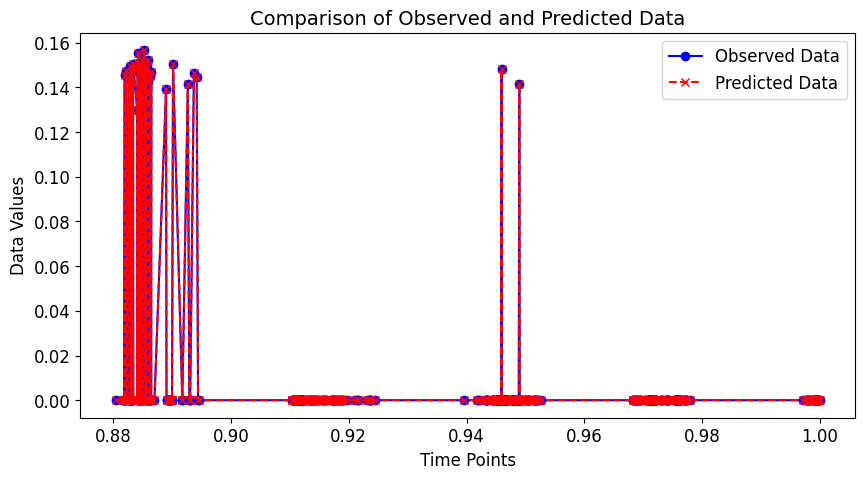

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# 첫 번째 배치의 데이터 로드
first_batch = next(iter(train_dataloader))

# observed_tp와 observed_data 추출

observed_tp = first_batch['observed_tp'].cpu().numpy()
observed_data = first_batch['observed_data'].cpu().numpy().squeeze()

# tp_to_predict와 data_to_predict 추출
tp_to_predict = first_batch['tp_to_predict'].cpu().numpy()
data_to_predict = first_batch['data_to_predict'].cpu().numpy().squeeze()
print(observed_data.shape)
print(observed_tp.shape)
# 그래프 그리기
plt.figure(figsize=(10, 5))

# 실제 관측된 데이터를 플롯
plt.plot(observed_tp, observed_data[2,:], label='Observed Data', marker='o', linestyle='-', color='blue')

# 예측된 데이터를 플롯
plt.plot(tp_to_predict, data_to_predict[2,:], label='Predicted Data', marker='x', linestyle='--', color='red')

plt.title('Comparison of Observed and Predicted Data')
plt.xlabel('Time Points')
plt.ylabel('Data Values')
plt.legend()
plt.show()


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.